In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as col
import seaborn as sns
import ast

# Generic Functions

In [2]:
def get_training_hyper(row, hyper="seed"):
    hypers = ast.literal_eval(row["config/training"])
    return hypers[hyper]

def get_d_hypers(row, hyper="n_hidden_units"):
    hypers = ast.literal_eval(row["config/discriminator"])
    return hypers[hyper] 

def get_g_hypers(row, hyper="n_hidden_units"):
    hypers = ast.literal_eval(row["config/generator"])
    return hypers[hyper] 

def get_expanded_df(results_df, optim="sgd", separate_momentum=False):
    
    # List the training hyperparameters
    if optim == "sgd":
        if separate_momentum:
            training_hypers = ["seed", "d_lr", "g_lr", "gamma", "d_momentum", "g_momentum", "step_size"]
        else:
            training_hypers = ["seed", "d_lr", "g_lr", "gamma", "momentum", "step_size"]
        precise_cols = training_hypers[1:5]
    elif optim == "adam":
        training_hypers = ["seed", "d_lr", "g_lr", "gamma", "g_betas", "d_betas", "step_size"]
        precise_cols = training_hypers[1:4]
    else:
        raise Exception(f"optimizer {optim} not recognized")

    # List the discriminator and generator network hyperparameters
    nn_hypers = ["n_hidden_units", "n_hidden_layers"]

    # Add a new column for each training hyperparameter
    for hyper in training_hypers:
        results_df[hyper] = results_df.apply(lambda row: get_training_hyper(row, hyper), axis=1)
        
    # Extract beta parameters if Adam optimizer is used
    if optim == "adam":
        results_df["g_betas"] = results_df["g_betas"].apply(lambda row: row.strip('][').split())
        results_df["d_betas"] = results_df["d_betas"].apply(lambda row: row.strip('][').split())

    # Add a new column for each discriminator and generator hyperparameter
    for hyper in nn_hypers:
        results_df["d_"+hyper] = results_df.apply(lambda row: get_d_hypers(row, hyper), axis=1)
        results_df["g_"+hyper] = results_df.apply(lambda row: get_g_hypers(row, hyper), axis=1)
        
    # Increase precision of several hypers
    for col in precise_cols:
        results_df[col] = results_df[col].map(lambda x: '{0:.17}'.format(x))
        
    # Drop unnecessary columns
    results_df = results_df.drop(["time_this_iter_s", "done", "timesteps_total", "episodes_total", 
                                  "training_iteration", "experiment_id", "timestamp", "time_total_s", 
                                  "pid", "node_ip", "time_since_restore", "timesteps_since_restore", 
                                  "iterations_since_restore", "trial_id", "config/generator", 
                                  "config/discriminator", "config/problem", "config/training"], axis=1)   
    return results_df

In [3]:
def plot_results(results_df, x, y, max_mse=1):
    fig, ax = plt.subplots(figsize=(10,8))
    results_df = results_df[results_df["mean_squared_error"]<max_mse].copy()
    x_vals = [float(x_i) for x_i in results_df[x]]
    y_vals = [float(y_i) for y_i in results_df[y]]
    sp = ax.scatter(x_vals, y_vals, c=results_df["mean_squared_error"], norm=col.LogNorm())
    cb = fig.colorbar(sp, ax=ax)
    cb.set_label("Mean squared error", rotation=270)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    plt.show()
    
def plot_bivariate(results_df, max_mse=1):
    fig, axs = plt.subplots(2, 4, figsize=(14,8))
    results_df = results_df[results_df["mean_squared_error"]<max_mse].copy()
    axs = axs.ravel()
    features = ["d_lr", "g_lr", "gamma", "step_size", "g_betas", "d_betas"]
    for i, feature in enumerate(features):
        y_vals = [float(y_i) for y_i in results_df["mean_squared_error"]]
        if feature == "g_betas":
            lists = results_df[feature].to_numpy()
            for j in range(2):
                x_vals = [float(l[j]) for l in lists]
                axs[i+j].scatter(x_vals, y_vals)
                axs[i+j].set_xlabel(f"{feature}_{j}")
                axs[i+j].set_yscale("log")
        elif feature == "d_betas":
            lists = results_df[feature].to_numpy()
            for j in range(2):
                x_vals = [float(l[j]) for l in lists]
                axs[i+j+1].scatter(x_vals, y_vals)
                axs[i+j+1].set_xlabel(f"{feature}_{j}")
                axs[i+j+1].set_yscale("log")
        else:
            x_vals = [float(x_i) for x_i in results_df[feature]]
            axs[i].scatter(x_vals, y_vals)
            axs[i].set_xlabel(feature)
            axs[i].set_yscale("log")
    plt.tight_layout()

# 1. EXP

In [4]:
# Read in the EXP results
exp_results = pd.read_csv("fasrc_results/ray_tune_exp_adam.csv", usecols=np.arange(1,22))
exp_results = get_expanded_df(exp_results, optim="adam")
exp_results.loc[exp_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
344,3.182350e-16,2021-10-04_00-34-42,holy7c24203.rc.fas.harvard.edu,0,0.003463728449223625,0.064090137485700235,0.94530362439311566,"[0.53031704, 0.3746971]","[0.11049184, 0.61258848]",2,40,30,5,5
249,3.182350e-16,2021-10-04_00-34-12,holy7c24203.rc.fas.harvard.edu,1,0.0152970175031675,0.078605929822058052,0.96357947980181735,"[0.42361053, 0.52804964]","[0.26906948, 0.88788478]",3,20,40,3,3
1007,3.182350e-16,2021-10-04_00-39-09,holy7c24203.rc.fas.harvard.edu,2,0.097506579814443814,0.077674898674501128,0.93757903992043412,"[0.65269048, 0.66281278]","[0.40414071, 0.57584149]",3,20,50,4,4
116,3.182350e-16,2021-10-04_00-33-32,holy7c24203.rc.fas.harvard.edu,3,0.035732925640479127,0.060308911115170581,0.90467347451035574,"[0.23153678, 0.83059213]","[0.06683732, 0.26089678]",8,50,50,4,4
18,3.182350e-16,2021-10-04_00-32-46,holy7c24203.rc.fas.harvard.edu,4,0.0098003953476289898,0.033256070589426749,0.94248317439104889,"[0.42579896, 0.89779523]","[0.28879025, 0.71445169]",6,30,50,2,5
175,3.182350e-16,2021-10-04_00-33-53,holy7c24203.rc.fas.harvard.edu,5,0.0067945292193244775,0.055691327344828172,0.93719261819044797,"[0.16960435, 0.61929928]","[0.03860631, 0.84166817]",7,30,40,5,2
118,3.182350e-16,2021-10-04_00-33-34,holy7c24203.rc.fas.harvard.edu,6,0.0096129385952840388,0.07741629065313653,0.91454140826703012,"[0.73041718, 0.18698354]","[0.92884044, 0.59578656]",9,30,40,3,5
28,3.182350e-16,2021-10-04_00-32-42,holy7c24203.rc.fas.harvard.edu,7,0.0071123949776022597,0.094548446005977366,0.93211242821420071,"[0.18245262, 0.22982304]","[0.07957338, 0.54931604]",6,50,30,2,4
60,3.182350e-16,2021-10-04_00-33-02,holy7c24203.rc.fas.harvard.edu,8,0.0075996472493229279,0.060733680055341507,0.9618182793473492,"[0.18816457, 0.40685192]","[0.5633916, 0.16836895]",4,40,50,2,3
24,3.182350e-16,2021-10-04_00-32-48,holy7c24203.rc.fas.harvard.edu,9,0.088331316132474386,0.05857065401447941,0.96775940941054295,"[0.64147684, 0.7256815]","[0.4321078, 0.62824842]",2,20,50,5,5


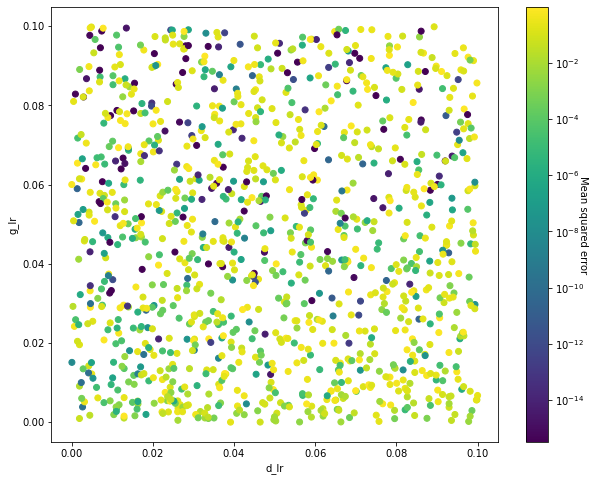

In [5]:
plot_results(exp_results, "d_lr", "g_lr")

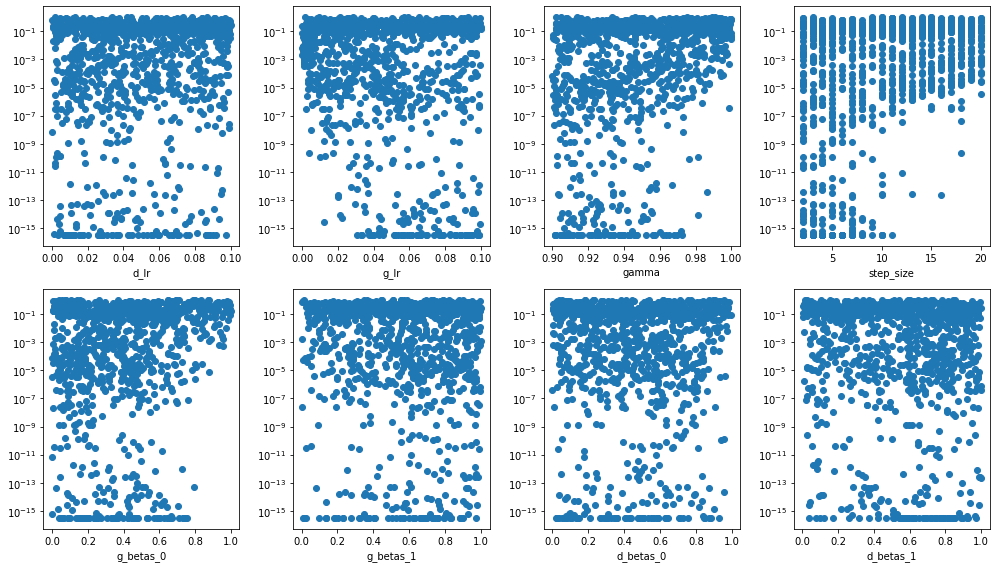

In [6]:
plot_bivariate(exp_results)

# 2. SHO

In [7]:
# Read in the first SHO results
sho_results = pd.read_csv("fasrc_results/ray_tune_sho_adam_0.csv", usecols=np.arange(1,22))
sho_results = get_expanded_df(sho_results, optim="adam")
sho_results.loc[sho_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1211,2.700784e-12,2021-10-03_10-50-11,holy7c24202.rc.fas.harvard.edu,0,0.00048861147485534354,0.0059646176842056914,0.97862221657386639,"[0.36317042, 0.75224866]","[0.58413382, 0.45382877]",19,50,40,3,3


In [8]:
# Read in the second SHO results
sho_results = pd.read_csv("fasrc_results/ray_tune_sho_adam.csv", usecols=np.arange(1,22))
sho_results = get_expanded_df(sho_results, optim="adam")
sho_results.loc[sho_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
100,3.754975e-11,2021-10-04_00-51-06,holy7c24402.rc.fas.harvard.edu,0,0.0596631966011004,0.052711308084911646,0.97673090515008942,"[0.2986419, 0.81607355]","[0.79298811, 0.78714233]",6,30,40,2,3
525,2.414083e-11,2021-10-04_01-03-42,holy7c24402.rc.fas.harvard.edu,1,0.081482013451084176,0.020972895200746178,0.95294270439114248,"[0.15865097, 0.1759868]","[0.92397234, 0.94538982]",17,50,40,4,3
1301,2.000985e-10,2021-10-04_01-22-33,holy7c24402.rc.fas.harvard.edu,2,0.079497165921974283,0.03491452380287291,0.93603151335046308,"[0.48017221, 0.78748983]","[0.7407101, 0.52394735]",14,20,40,4,3
1291,1.377069e-11,2021-10-04_01-23-05,holy7c24402.rc.fas.harvard.edu,3,0.026883169370463558,0.035039045212932593,0.94587748195993748,"[0.30716221, 0.31269132]","[0.25308692, 0.02017877]",20,30,20,3,4
1481,1.151153e-11,2021-10-04_01-28-57,holy7c24402.rc.fas.harvard.edu,4,0.019730582492406418,0.030190897197148844,0.97475698088344165,"[0.38809487, 0.95213816]","[0.50725869, 0.1377562]",14,40,20,4,2
1381,6.049151e-11,2021-10-04_01-25-30,holy7c24402.rc.fas.harvard.edu,5,0.057384705059999597,0.011985199935741427,0.95435734973137831,"[0.25453221, 0.90907967]","[0.62094987, 0.40289959]",19,50,30,2,3
380,2.140888e-11,2021-10-04_00-58-51,holy7c24402.rc.fas.harvard.edu,6,0.035088855656472025,0.027207231798821147,0.91253680827666084,"[0.24387189, 0.59774168]","[0.55464001, 0.28889915]",19,30,50,3,2
1532,7.130555e-11,2021-10-04_01-31-14,holy7c24402.rc.fas.harvard.edu,7,0.0069589833435060927,0.011322316686995454,0.97206854381773034,"[0.07110746, 0.94132838]","[0.11494515, 0.03258803]",16,20,30,3,4
1253,1.368435e-11,2021-10-04_01-21-28,holy7c24402.rc.fas.harvard.edu,8,0.060711032031526529,0.017468124046990455,0.94342461439275993,"[0.19005483, 0.7928569]","[0.11367535, 0.0144229]",16,50,40,4,2
1780,3.132567e-11,2021-10-04_01-35-39,holy7c24402.rc.fas.harvard.edu,9,0.091212475745311813,0.017452264687020023,0.95018516322343305,"[0.03027838, 0.77961905]","[0.32926089, 0.19495461]",15,30,40,2,2


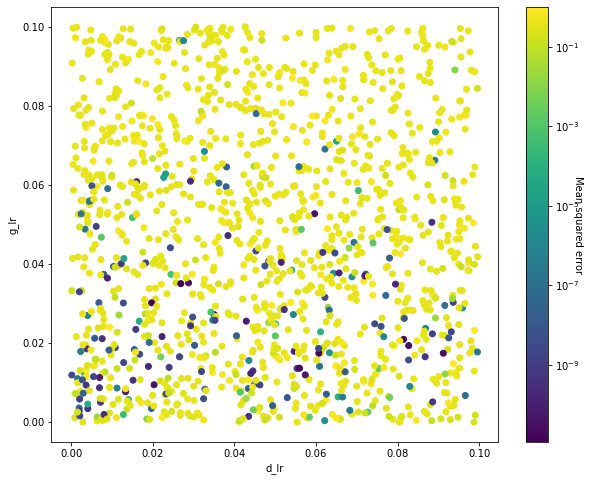

In [9]:
plot_results(sho_results, "d_lr", "g_lr")

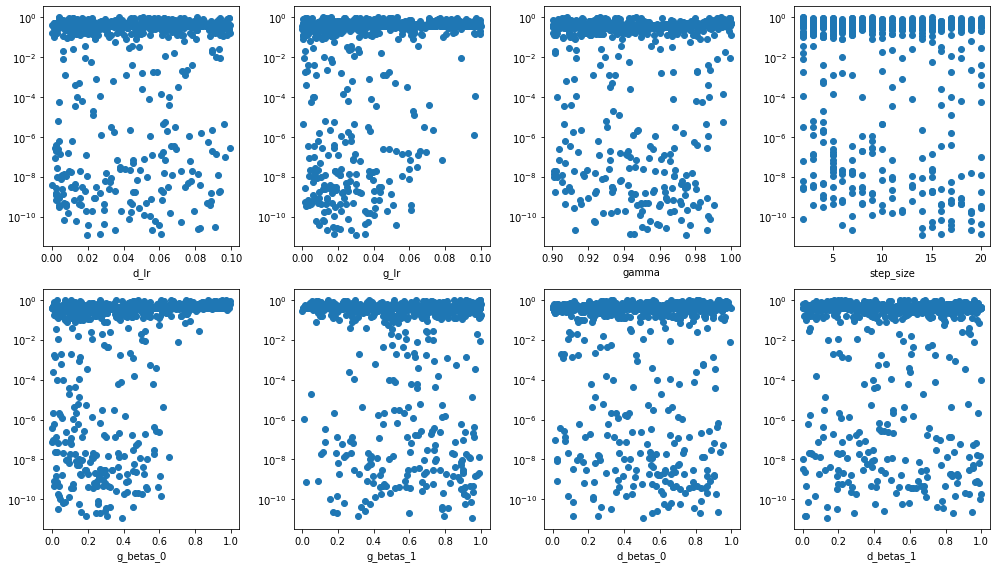

In [10]:
plot_bivariate(sho_results)

# 3. NLO

In [11]:
# Read in the first NLO results
nlo_results = pd.read_csv("fasrc_results/ray_tune_nlo_adam_0.csv", usecols=np.arange(1,22))
nlo_results = get_expanded_df(nlo_results, optim="adam")
nlo_results.loc[nlo_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1807,7.681183e-13,2021-10-03_12-05-24,holy7c24203.rc.fas.harvard.edu,0,0.02104329548894603,0.010648723263851936,0.98037812391306267,"[0.22544921, 0.33148318]","[0.36273349, 0.55130697]",15,20,40,2,4


In [12]:
# Read in the second NLO results
nlo_results = pd.read_csv("fasrc_results/ray_tune_nlo_adam.csv", usecols=np.arange(1,22))
nlo_results = get_expanded_df(nlo_results, optim="adam")
nlo_results.loc[nlo_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
284,9.808947e-10,2021-10-04_02-01-49,holy7c24203.rc.fas.harvard.edu,0,0.078757774287542187,0.057909099876832029,0.9630903539432345,"[0.14775712, 0.96484908]","[0.66156042, 0.80956499]",13,30,40,2,2
415,2.477026e-11,2021-10-04_02-15-57,holy7c24203.rc.fas.harvard.edu,1,0.053315184448687492,0.015473814091325765,0.99727513521880695,"[0.12763741, 0.63022683]","[0.63737985, 0.56072805]",5,20,20,2,4
163,2.325411e-11,2021-10-04_02-00-33,holy7c24203.rc.fas.harvard.edu,2,0.038311077314438662,0.015022903009935732,0.99210646762779864,"[0.0007779, 0.4103747]","[0.4396353, 0.97088812]",9,20,30,2,5
1252,2.144644e-11,2021-10-04_02-55-23,holy7c24203.rc.fas.harvard.edu,3,0.065515162353922643,0.0098007846645461315,0.98249102516659292,"[0.7524641, 0.93424283]","[0.85173115, 0.77125918]",18,20,30,2,4
1305,1.177579e-10,2021-10-04_02-52-43,holy7c24203.rc.fas.harvard.edu,4,0.080131021892641818,0.031406284938896807,0.95807223432904531,"[0.0386128, 0.48618842]","[0.37943322, 0.74241767]",8,50,40,3,2
1832,1.405828e-11,2021-10-04_03-22-36,holy7c24203.rc.fas.harvard.edu,5,0.054268860988652641,0.028273693898291843,0.97731931039021869,"[0.34638868, 0.87557239]","[0.32652425, 0.38327061]",17,40,50,2,2
1075,6.206875e-11,2021-10-04_02-42-48,holy7c24203.rc.fas.harvard.edu,6,0.032902816013771354,0.012344431104217121,0.94696271913397401,"[0.22870481, 0.35836412]","[0.7326032, 0.88042452]",19,40,30,4,5
1882,1.105297e-10,2021-10-04_03-22-44,holy7c24203.rc.fas.harvard.edu,7,0.011152825468485551,0.01514217009452553,0.93454392136809183,"[0.06337378, 0.51350646]","[0.53766632, 0.92900947]",15,50,50,2,4
1226,9.346169e-11,2021-10-04_02-56-54,holy7c24203.rc.fas.harvard.edu,8,0.035189586751030809,0.0029219054228305972,0.98873793195803494,"[0.12110837, 0.71524234]","[0.40615609, 0.76406156]",12,20,50,2,5
575,7.861828e-12,2021-10-04_02-24-42,holy7c24203.rc.fas.harvard.edu,9,0.02530252267379016,0.012594526246066931,0.997966413094176,"[0.14728888, 0.83252982]","[0.81857537, 0.40475608]",3,50,30,2,4


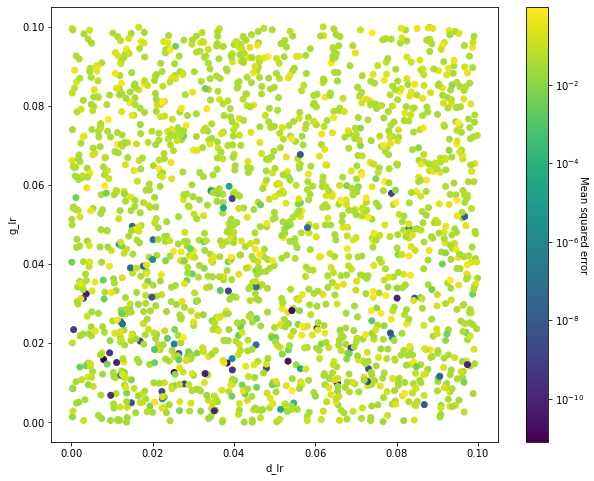

In [13]:
plot_results(nlo_results, "d_lr", "g_lr")

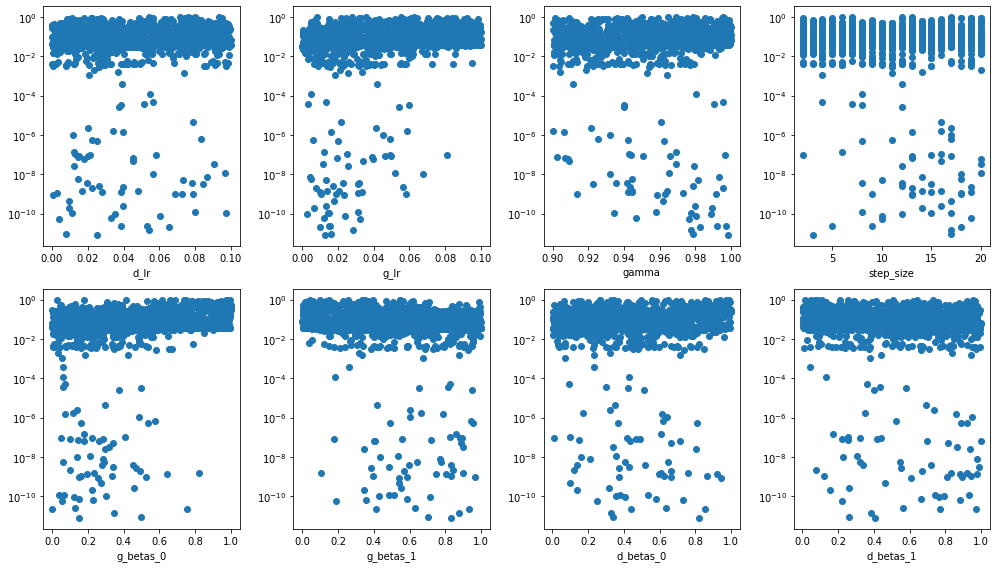

In [14]:
plot_bivariate(nlo_results)

# 4. POS

In [15]:
# Read in the first POS results
pos_results = pd.read_csv("fasrc_results/ray_tune_pos_adam_0.csv", usecols=np.arange(1,22))
pos_results = get_expanded_df(pos_results, optim="adam")
pos_results.loc[pos_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
938,6.398321e-13,2021-10-03_11-33-14,holy7c24201.rc.fas.harvard.edu,0,0.02154824129565415,0.019086634787137204,0.95727502453840718,"[0.13931808, 0.36966975]","[0.74574617, 0.7590883]",9,30,50,2,4


In [16]:
# Read in the second POS results
pos_results = pd.read_csv("fasrc_results/ray_tune_pos_adam.csv", usecols=np.arange(1,22))
pos_results = get_expanded_df(pos_results, optim="adam")
pos_results.loc[pos_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
997,2.674505e-12,2021-10-04_03-59-30,holy7c24204.rc.fas.harvard.edu,0,0.002862002287040295,0.039911848889371215,0.91814314929064222,"[0.44946785, 0.67016223]","[0.31598038, 0.05736258]",13,50,50,4,2
548,6.910650e-12,2021-10-04_03-51-23,holy7c24204.rc.fas.harvard.edu,1,0.057298925024592481,0.016586868864287833,0.90357097426250998,"[0.03806089, 0.03315012]","[0.33871399, 0.93239932]",19,30,50,2,4
415,1.697799e-12,2021-10-04_03-47-52,holy7c24204.rc.fas.harvard.edu,2,0.011109899699203585,0.051963063181141911,0.90549502145300442,"[0.15813326, 0.58541457]","[0.75701359, 0.92306149]",18,30,20,4,3
1992,4.065137e-12,2021-10-04_04-18-16,holy7c24204.rc.fas.harvard.edu,3,0.032343791399860142,0.050289954260823534,0.93761463063234418,"[0.11490233, 0.61101461]","[0.04168844, 0.81135499]",11,30,50,3,2
1157,2.022413e-12,2021-10-04_04-02-42,holy7c24204.rc.fas.harvard.edu,4,0.0022530499249221146,0.015233439230105537,0.92352631080597347,"[0.21238117, 0.34101081]","[0.72426908, 0.83563404]",16,50,50,2,3
1263,1.550480e-11,2021-10-04_04-03-16,holy7c24204.rc.fas.harvard.edu,5,0.022803476933138247,0.058329290830044164,0.93746838790134512,"[0.06428135, 0.57210522]","[0.62831873, 0.06302207]",9,20,20,2,4
1675,2.336244e-12,2021-10-04_04-13-11,holy7c24204.rc.fas.harvard.edu,6,0.0020348054417380001,0.046377606361762747,0.91589635730793684,"[0.24690103, 0.62241883]","[0.84348577, 0.59985862]",18,50,30,5,3
1698,2.374962e-12,2021-10-04_04-12-59,holy7c24204.rc.fas.harvard.edu,7,0.0040492191793375506,0.010205898712660437,0.94943630323069073,"[0.21645442, 0.3894066]","[0.47660815, 0.64173763]",12,30,40,4,2
1258,4.995612e-12,2021-10-04_04-06-40,holy7c24204.rc.fas.harvard.edu,8,0.025378810568192106,0.0067115008631685701,0.95936631558598862,"[0.58416337, 0.8549995]","[0.88298712, 0.96570292]",12,20,50,4,4
41,8.835623e-12,2021-10-04_03-41-33,holy7c24204.rc.fas.harvard.edu,9,0.09336123638994899,0.0075975444363885194,0.90967028498051161,"[0.08499967, 0.93407971]","[0.19908629, 0.5786902]",18,40,50,2,4


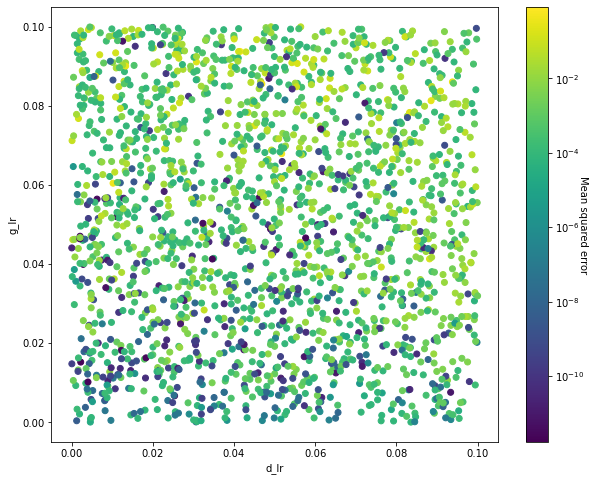

In [17]:
plot_results(pos_results, "d_lr", "g_lr")

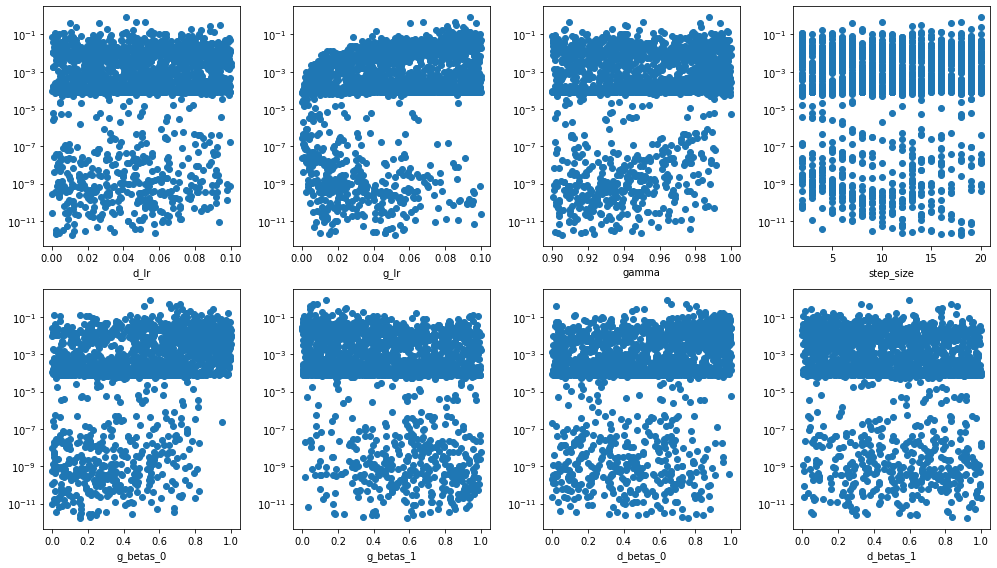

In [18]:
plot_bivariate(pos_results)

# 5. SIR

In [19]:
# Read in the SIR results
sir_results = pd.read_csv("fasrc_results/ray_tune_sir_adam_new.csv", usecols=np.arange(1,22))
sir_results = get_expanded_df(sir_results, optim="adam")
sir_results.loc[sir_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
596,6.156667e-05,2021-10-12_18-33-38,holy7c24301.rc.fas.harvard.edu,0,0.017579260186589628,0.034451952039986626,0.92149233741088388,"[0.11111877, 0.34393505]","[0.27511734, 0.01780552]",15,20,30,3,5
936,7.460055e-07,2021-10-12_19-06-29,holy7c24301.rc.fas.harvard.edu,1,0.026709950169583295,0.054584484598163167,0.98796095174984133,"[0.34511251, 0.49410708]","[0.57369865, 0.12496358]",15,50,20,2,3
601,2.282120e-08,2021-10-12_18-35-45,holy7c24301.rc.fas.harvard.edu,2,0.055852573882656187,0.036727431813311041,0.97183350403592317,"[0.05575282, 0.24209578]","[0.06706658, 0.96131978]",15,40,20,5,2
1050,1.711286e-09,2021-10-12_19-23-27,holy7c24301.rc.fas.harvard.edu,3,0.0048938616305375755,0.011746072513997606,0.99422115701902469,"[0.23990367, 0.24735706]","[0.21180557, 0.12231498]",15,30,50,3,3
161,3.918958e-07,2021-10-12_17-54-40,holy7c24301.rc.fas.harvard.edu,4,0.026706883947478804,0.051583725281754533,0.91410675093364857,"[0.38013809, 0.73582533]","[0.22341412, 0.0205174]",15,50,40,4,2
1740,8.256135e-05,2021-10-12_20-09-04,holy7c24301.rc.fas.harvard.edu,5,0.029657900788926328,0.018674665658307402,0.96764334446457845,"[0.15587178, 0.80166496]","[0.27684222, 0.32423394]",15,30,50,3,2
1997,9.729931e-09,2021-10-12_20-32-09,holy7c24301.rc.fas.harvard.edu,6,0.001324048869577965,0.016508029720849599,0.99156553688229698,"[0.20577781, 0.39938013]","[0.53829427, 0.68265652]",15,50,20,2,2
1054,1.093240e-04,2021-10-12_19-12-30,holy7c24301.rc.fas.harvard.edu,7,0.052822998736473295,0.077786109578677043,0.97477977740821875,"[0.32196359, 0.85219985]","[0.23828286, 0.94825907]",15,20,20,2,2
207,3.397119e-08,2021-10-12_18-04-59,holy7c24301.rc.fas.harvard.edu,8,0.048650473872476951,0.014543941769487173,0.9832661450279524,"[0.04352082, 0.95235106]","[0.17485836, 0.52809463]",15,50,30,4,2
346,9.912646e-07,2021-10-12_18-27-18,holy7c24301.rc.fas.harvard.edu,9,0.057628618134113678,0.0085065146757328965,0.99302233246445448,"[0.06028212, 0.59794421]","[0.35710909, 0.56631151]",15,40,40,5,2


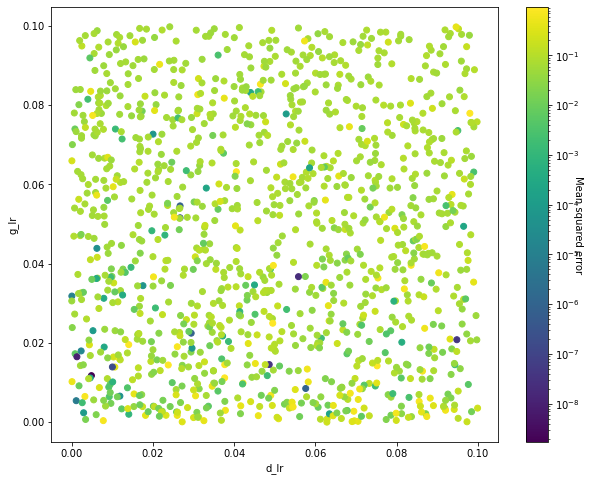

In [20]:
plot_results(sir_results, "d_lr", "g_lr")

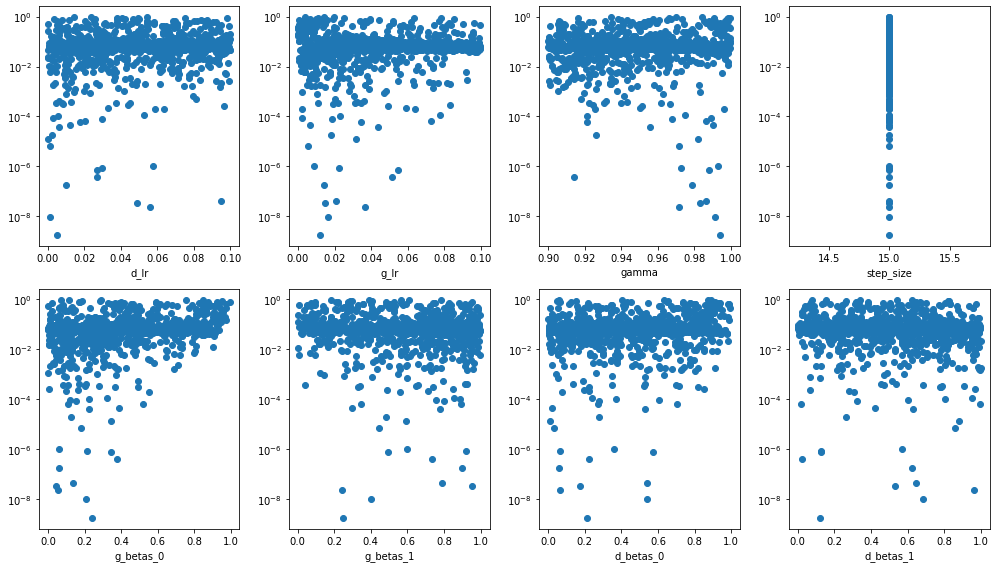

In [21]:
plot_bivariate(sir_results)

# 6. RANS

In [22]:
# Read in the RANS results
rans_results = pd.read_csv("fasrc_results/ray_tune_rans_adam.csv", usecols=np.arange(1,22))
rans_results = get_expanded_df(rans_results, optim="adam")
rans_results.loc[rans_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
12,159.826357,2021-10-04_12-29-33,holy7c24401.rc.fas.harvard.edu,0,0.047102637906597022,0.087290889611672293,0.95755480141023575,"[0.35706326, 0.45743051]","[0.05630037, 0.96237312]",2,20,40,4,2
49,162.921950,2021-10-04_12-40-28,holy7c24401.rc.fas.harvard.edu,1,0.013037888418553361,0.068179929128487693,0.91722048060475747,"[0.87877983, 0.74602319]","[0.06234685, 0.63103163]",9,50,20,3,3
51,161.607413,2021-10-04_12-40-14,holy7c24401.rc.fas.harvard.edu,2,0.077748558432677459,0.076515395502946462,0.92417279919135242,"[0.63717351, 0.35698444]","[0.29409961, 0.23383043]",13,40,50,3,3
13,156.151671,2021-10-04_12-30-14,holy7c24401.rc.fas.harvard.edu,3,0.058961726163355238,0.028452255507075089,0.95779376188963516,"[0.7654043, 0.64097131]","[0.83354928, 0.65191265]",12,40,50,5,2
144,158.580074,2021-10-04_13-37-28,holy7c24401.rc.fas.harvard.edu,4,0.054393571770575959,0.053718724748984169,0.94497176541005778,"[0.38566445, 0.95113745]","[0.36412546, 0.21496849]",3,40,20,3,3
68,124.108505,2021-10-04_12-42-06,holy7c24401.rc.fas.harvard.edu,5,0.038028006378184487,0.047213898930652975,0.92032519391415613,"[0.38403368, 0.43670135]","[0.96234936, 0.1028605]",20,30,50,5,3
114,138.253638,2021-10-04_13-07-50,holy7c24401.rc.fas.harvard.edu,6,0.048057269120813588,0.026402378704027226,0.95766592664024797,"[0.15207008, 0.87110651]","[0.88432302, 0.14975234]",9,40,30,3,5
66,160.587602,2021-10-04_12-42-44,holy7c24401.rc.fas.harvard.edu,7,0.094486036958194075,0.086274070812989545,0.93404764420015407,"[0.37594888, 0.52460457]","[0.88219594, 0.80796156]",15,40,30,3,4
176,161.915595,2021-10-04_13-40-39,holy7c24401.rc.fas.harvard.edu,8,0.033656041083068376,0.085933815423378759,0.91017047089719494,"[0.03062641, 0.76398511]","[0.22846284, 0.72158713]",6,50,30,3,2
151,153.241244,2021-10-04_13-29-11,holy7c24401.rc.fas.harvard.edu,9,0.070431661176774449,0.079383774321807182,0.98121480812943707,"[0.06006626, 0.90937366]","[0.36657204, 0.77572945]",13,30,40,4,2


## 6.1 Increased step sizes

Tuning with `step_size` bounds increased from [2,21] to [180,200].

In [23]:
# Read in the RANS results
rans_results = pd.read_csv("fasrc_results/ray_tune_rans_step_180.csv", usecols=np.arange(1,22))
rans_results = get_expanded_df(rans_results, optim="adam")
rans_results.loc[rans_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
167,148.332530,2021-10-05_00-22-59,holy7c24404.rc.fas.harvard.edu,0,0.099339814820519068,0.091419815971967591,0.91619276603094846,"[0.06794376, 0.87751384]","[0.35354866, 0.81849523]",187,40,30,5,3
105,106.002148,2021-10-04_23-47-31,holy7c24404.rc.fas.harvard.edu,1,0.013129078076143974,0.083953884162904516,0.90830868483317484,"[0.4536513, 0.84105801]","[0.82558762, 0.21714504]",188,30,30,5,2
88,161.302927,2021-10-04_23-43-05,holy7c24404.rc.fas.harvard.edu,2,0.07870666012900962,0.012728947326541201,0.93445092005092178,"[0.75523683, 0.16254932]","[0.91141681, 0.34991591]",198,20,40,3,5
72,149.382446,2021-10-04_23-33-27,holy7c24404.rc.fas.harvard.edu,3,0.059452251898617331,0.043331910468857981,0.95421956919249185,"[0.05469262, 0.93214652]","[0.76317734, 0.22930341]",189,30,40,2,4
21,147.224971,2021-10-04_23-26-21,holy7c24404.rc.fas.harvard.edu,4,0.016437031559906733,0.050577965339591746,0.99389608047800071,"[0.55490866, 0.8822928]","[0.53158871, 0.8049228]",189,30,30,4,4
26,161.959063,2021-10-04_23-20-21,holy7c24404.rc.fas.harvard.edu,5,0.0079000518254977118,0.063548373283614457,0.97107516067680721,"[0.21127108, 0.812236]","[0.55856429, 0.9270129]",182,50,40,5,2
58,156.943443,2021-10-04_23-33-01,holy7c24404.rc.fas.harvard.edu,6,0.0062620415687378523,0.039506738683275582,0.93704891996177608,"[0.36411012, 0.54143152]","[0.0329338, 0.12806263]",195,40,20,3,5
60,116.923019,2021-10-04_23-41-39,holy7c24404.rc.fas.harvard.edu,7,0.032825176378964857,0.022129222306069073,0.9163184698059601,"[0.33675016, 0.58870395]","[0.88221207, 0.66547313]",180,50,30,4,2
0,100.698494,2021-10-04_23-20-16,holy7c24404.rc.fas.harvard.edu,8,0.078454964937072783,0.077056166725618339,0.90982426867466115,"[0.50782583, 0.6315784]","[0.7994576, 0.10848767]",195,40,30,4,2
67,147.999123,2021-10-04_23-32-47,holy7c24404.rc.fas.harvard.edu,9,0.069753793504486308,0.042105229228086224,0.94516660205002656,"[0.89798816, 0.54464049]","[0.51648079, 0.17254799]",181,50,20,5,4


# 7. COO

In [24]:
# Read in the COO results
coo_results = pd.read_csv("fasrc_results/ray_tune_coo_adam.csv", usecols=np.arange(1,22))
coo_results = get_expanded_df(coo_results, optim="adam")
coo_results.loc[coo_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
557,2.483194e-01,2021-10-16_12-37-13,holy7c24201.rc.fas.harvard.edu,0,0.039246600978446816,0.011829865004749592,0.91985048532973279,"[0.61536114, 0.45984507]","[0.84191029, 0.41882645]",19,30,20,2,4
948,4.524419e-08,2021-10-16_13-37-53,holy7c24201.rc.fas.harvard.edu,1,0.082286188095080953,0.0042151418408642683,0.99756482157907311,"[0.60325852, 0.61447363]","[0.41218949, 0.11003992]",16,40,40,2,5
203,1.923728e-01,2021-10-16_12-04-46,holy7c24201.rc.fas.harvard.edu,2,0.055689674116320358,0.046694283003550337,0.97095767741962735,"[0.07391431, 0.36827023]","[0.08150694, 0.61480754]",13,40,20,2,3
564,2.395774e-01,2021-10-16_12-39-24,holy7c24201.rc.fas.harvard.edu,3,0.0039382350314899183,0.0076367845603473785,0.95923909958589448,"[0.29683833, 0.1316118]","[0.93607832, 0.75782043]",11,30,30,5,3
1286,2.619943e-01,2021-10-16_13-51-08,holy7c24201.rc.fas.harvard.edu,4,0.052170899616416987,0.0061562943607780347,0.97622257664417089,"[0.00561211, 0.56634871]","[0.80638658, 0.74141113]",7,50,30,3,4
970,2.305903e-01,2021-10-16_13-18-08,holy7c24201.rc.fas.harvard.edu,5,0.074937220353053696,0.0086941463637413129,0.98753003395920202,"[0.50736104, 0.60153803]","[0.62280355, 0.90342149]",4,40,20,2,4
1468,2.356418e-01,2021-10-16_14-09-19,holy7c24201.rc.fas.harvard.edu,6,0.0014694256008514549,0.046985011672084867,0.93154291853503579,"[0.42620914, 0.29497788]","[0.50074863, 0.86940254]",20,20,20,2,2
438,2.413512e-01,2021-10-16_12-25-26,holy7c24201.rc.fas.harvard.edu,7,0.036436082778760856,0.015937652799133829,0.95959567203648877,"[0.45100989, 0.50820223]","[0.86121807, 0.8849093]",9,30,20,3,2
1084,2.346029e-01,2021-10-16_13-29-07,holy7c24201.rc.fas.harvard.edu,8,0.090870321541714497,0.0051103693637390242,0.96614183164276835,"[0.56776699, 0.55204843]","[0.66552172, 0.4534717]",17,30,50,3,2
66,1.710943e-01,2021-10-16_11-48-48,holy7c24201.rc.fas.harvard.edu,9,0.0028788231906645982,0.016131652662052378,0.98623229166201964,"[0.1046891, 0.62406552]","[0.86789091, 0.63042278]",5,40,50,3,2


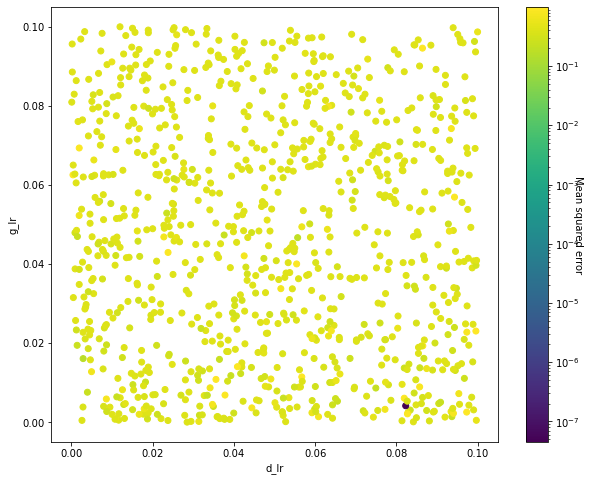

In [25]:
plot_results(coo_results, "d_lr", "g_lr")

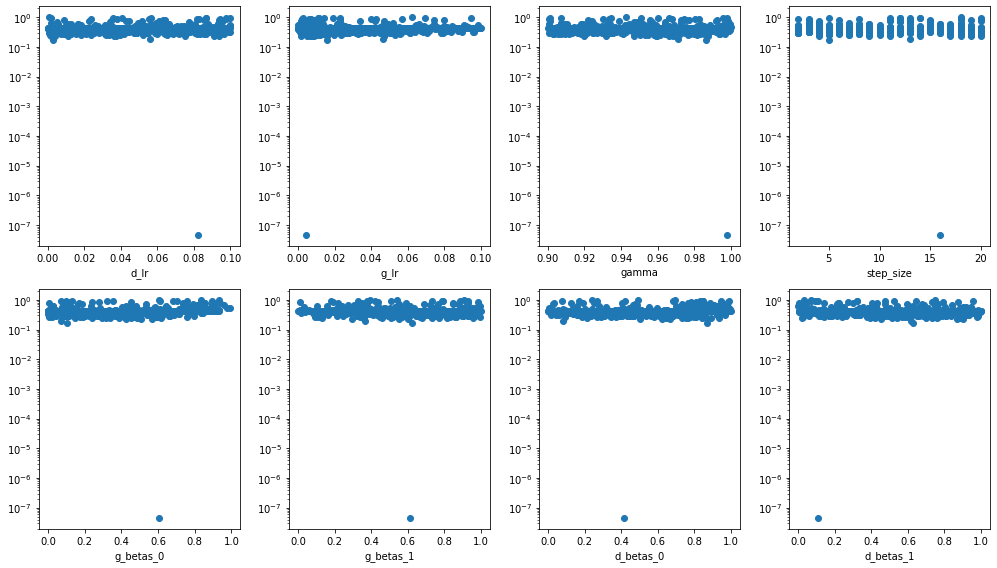

In [56]:
plot_bivariate(coo_results)

# 8. WAV

In [26]:
# Read in the WAV results
wav_results = pd.read_csv("fasrc_results/ray_tune_wav_adam.csv", usecols=np.arange(1,22))
wav_results = get_expanded_df(wav_results, optim="adam")
wav_results.loc[wav_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1370,1.104161e-08,2021-10-23_21-36-47,holy7c18312.rc.fas.harvard.edu,0,0.052332314332198981,0.038445110278490964,0.96834856027601979,"[0.51460513, 0.78576023]","[0.51778489, 0.20388569]",15,50,20,2,3
1748,2.713383e-08,2021-10-23_21-51-48,holy7c18312.rc.fas.harvard.edu,1,0.071004835544342004,0.012915989603012242,0.97354697490660536,"[0.04045274, 0.66993844]","[0.73344429, 0.10333145]",15,30,40,2,3
1655,2.853997e-08,2021-10-23_21-50-16,holy7c18312.rc.fas.harvard.edu,2,0.020471970258897777,0.0075283170205287155,0.98946019292035547,"[0.62524482, 0.78950836]","[0.41636603, 0.04255884]",16,20,20,5,5
641,1.285749e-08,2021-10-23_21-11-46,holy7c18312.rc.fas.harvard.edu,3,0.083519512402080595,0.014703163749818228,0.97233687328824514,"[0.63088288, 0.61488355]","[0.27542907, 0.47664216]",17,30,30,2,2
462,1.732102e-08,2021-10-23_21-05-12,holy7c18312.rc.fas.harvard.edu,4,0.02407061390045033,0.015243223366449916,0.95536263412416522,"[0.30113667, 0.79930577]","[0.1579113, 0.1755364]",17,40,50,2,2
1026,7.832441e-08,2021-10-23_21-24-27,holy7c18312.rc.fas.harvard.edu,5,0.090707819801933695,0.0099918847978794478,0.94842631440092706,"[0.0101174, 0.67631232]","[0.53867025, 0.96607522]",19,50,50,2,2
53,6.516200e-09,2021-10-23_20-51-40,holy7c18312.rc.fas.harvard.edu,6,0.0001176382403693117,0.019087237793961168,0.96569463805888156,"[0.67499221, 0.790766]","[0.09926623, 0.17844521]",19,30,20,2,4
522,3.114213e-07,2021-10-23_21-06-05,holy7c18312.rc.fas.harvard.edu,7,0.075353948064949675,0.025229536447072813,0.95689210726969987,"[0.16846918, 0.70422515]","[0.84743454, 0.79461788]",15,20,20,2,2
1378,1.778459e-07,2021-10-23_21-35-49,holy7c18312.rc.fas.harvard.edu,8,0.05452256910626524,0.019642670029566576,0.93532321267329688,"[0.65843324, 0.64003827]","[0.51379814, 0.17329707]",17,50,30,4,2
1196,6.722187e-09,2021-10-23_21-32-55,holy7c18312.rc.fas.harvard.edu,9,0.088441066074259264,0.012124383626117501,0.95336880203327612,"[0.29551987, 0.35822444]","[0.5751795, 0.13306347]",18,50,50,2,4


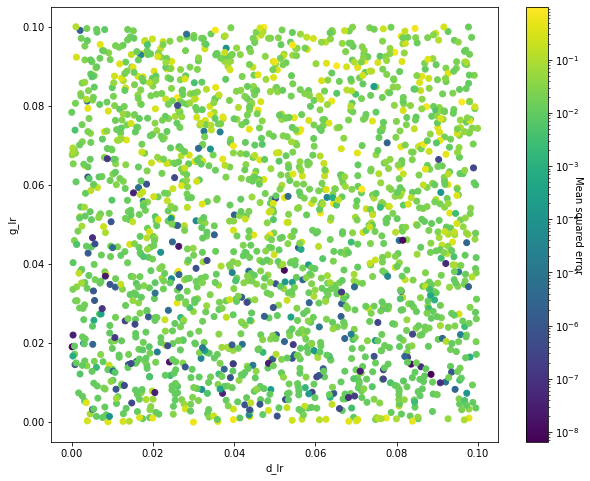

In [27]:
plot_results(wav_results, "d_lr", "g_lr")

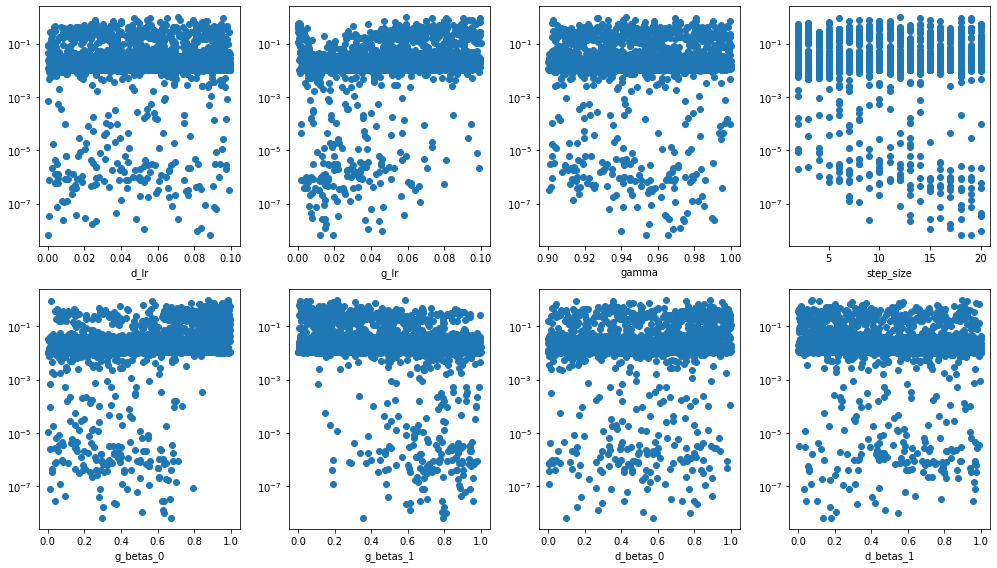

In [28]:
plot_bivariate(wav_results)

# 9. BUR

After the first round of hyperparameter tuning, I obtained no good results and noticed that BUR seems to prefer smaller learning rates. After changing the learning rate bound and rerunning, I got great results! This indicates the importance (and sensitivity) of the hyperparameter search space. I should try this on other experiments like SIR and COO.

In [52]:
# Read in the BUR results
bur_results = pd.read_csv("fasrc_results/ray_tune_bur_adam.csv", usecols=np.arange(1,22))
bur_results = get_expanded_df(bur_results, optim="adam")
bur_results.loc[bur_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
324,5.385410e-08,2021-10-31_21-03-38,holy7c24101.rc.fas.harvard.edu,0,0.012282615331308139,0.011440048157738242,0.93610392311907453,"[0.30218034, 0.30760473]","[0.47405901, 0.68369699]",16,40,30,4,2
1253,2.412334e-07,2021-10-31_22-06-30,holy7c24101.rc.fas.harvard.edu,1,0.0041122180809027489,0.010887437546214119,0.98737017257635018,"[0.02094906, 0.07560133]","[0.18543664, 0.5298049]",2,20,30,5,2
1576,6.179391e-08,2021-10-31_22-32-43,holy7c24101.rc.fas.harvard.edu,2,0.0041396589952699655,0.011433352976194156,0.97578463620388511,"[0.17524756, 0.68043969]","[0.28010914, 0.92929655]",12,30,20,4,4
687,1.966154e-07,2021-10-31_21-26-54,holy7c24101.rc.fas.harvard.edu,3,0.013137722358748749,0.01265323303613039,0.9421595423676884,"[0.65627937, 0.86189406]","[0.73664029, 0.48100027]",7,40,20,3,3
1366,1.694258e-07,2021-10-31_22-17-27,holy7c24101.rc.fas.harvard.edu,4,0.0084352997713489052,0.0089510993143552871,0.98597249113184593,"[0.49177472, 0.52979116]","[0.51064432, 0.14613542]",7,20,40,5,3
1307,5.342924e-08,2021-10-31_22-13-44,holy7c24101.rc.fas.harvard.edu,5,0.016212872106406095,0.0095161591058534507,0.99528167845766868,"[0.32611709, 0.69066128]","[0.14563415, 0.95943977]",10,20,40,4,2
624,7.979324e-08,2021-10-31_21-27-01,holy7c24101.rc.fas.harvard.edu,6,0.0098180422922734996,0.0074258187995654536,0.99028787053585132,"[0.54830603, 0.9439343]","[0.586497, 0.74985142]",8,40,20,4,2
1646,2.870849e-07,2021-10-31_22-35-59,holy7c24101.rc.fas.harvard.edu,7,0.0074246591279252009,0.0074521901715635924,0.97092005136143744,"[0.01038951, 0.32687226]","[0.77173564, 0.92221883]",4,50,30,2,3
1548,4.142000e-08,2021-10-31_22-29-06,holy7c24101.rc.fas.harvard.edu,8,0.018668908624606427,0.0098782335251924609,0.96069422018795247,"[0.35992336, 0.29183631]","[0.82707993, 0.80996696]",12,20,30,3,3
137,2.682271e-07,2021-10-31_20-48-51,holy7c24101.rc.fas.harvard.edu,9,0.0081489846289725214,0.013368227984130367,0.95594267757342366,"[0.35012201, 0.30062766]","[0.56027264, 0.8802193]",3,20,40,4,4


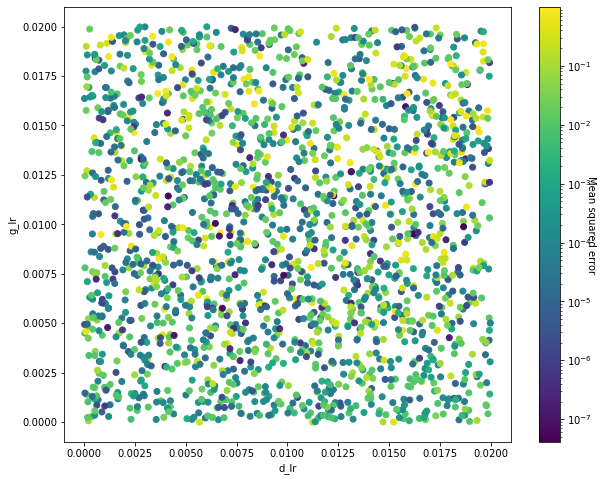

In [54]:
plot_results(bur_results, "d_lr", "g_lr")

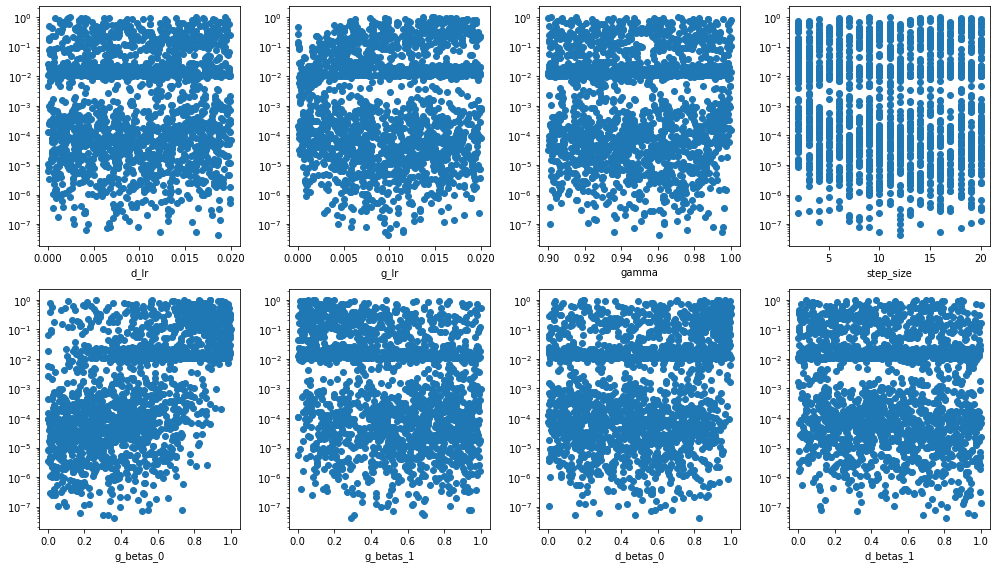

In [53]:
plot_bivariate(bur_results)

# 10. BURV

In [15]:
# Read in the BURV results
burv_results = pd.read_csv("fasrc_results/ray_tune_burv_adam.csv", usecols=np.arange(1,22))
burv_results = get_expanded_df(burv_results, optim="adam")
burv_results.loc[burv_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
396,0.000210,2021-11-16_00-41-57,holy7c24204.rc.fas.harvard.edu,0,0.0094448702495695033,0.010869217366330208,0.97731710019944196,"[0.53378653, 0.47055685]","[0.04492462, 0.4971588]",12,50,50,5,3
992,0.000196,2021-11-16_02-28-37,holy7c24204.rc.fas.harvard.edu,1,0.0080060039216701059,0.0066561132805317983,0.98774309734474741,"[0.64605346, 0.75827368]","[0.49188434, 0.23630881]",15,40,20,4,4
1076,0.000190,2021-11-16_02-32-10,holy7c24204.rc.fas.harvard.edu,2,0.0037935152609284389,0.01419182684992092,0.98400021927489023,"[0.18431666, 0.5183879]","[0.11145376, 0.17149793]",10,20,20,5,3
1501,0.000216,2021-11-16_03-42-38,holy7c24204.rc.fas.harvard.edu,3,0.0020282414143569477,0.0090820532654038444,0.96983734422914292,"[0.36835987, 0.71392151]","[0.17192266, 0.43436124]",13,20,50,2,4
1969,0.000192,2021-11-16_04-58-54,holy7c24204.rc.fas.harvard.edu,4,0.0027154880952418273,0.006905465750965162,0.99239166261998313,"[0.72347792, 0.9896715]","[0.15246561, 0.67809375]",19,30,20,3,3
1321,0.000187,2021-11-16_03-11-24,holy7c24204.rc.fas.harvard.edu,5,0.00618748813783927,0.014081443787627896,0.98193769158590383,"[0.08046137, 0.492928]","[0.0712502, 0.46208282]",12,40,20,5,4
583,0.000197,2021-11-16_01-08-38,holy7c24204.rc.fas.harvard.edu,6,0.0067866969625723552,0.019035412197866596,0.97233968469828957,"[0.71576386, 0.7182048]","[0.36481189, 0.66346519]",15,20,20,4,5
1906,0.000191,2021-11-16_04-57-23,holy7c24204.rc.fas.harvard.edu,7,0.0017023979591741932,0.013841670203232069,0.99024126805953183,"[0.46017136, 0.81388974]","[0.51024148, 0.96455714]",10,20,30,2,5
1319,0.000192,2021-11-16_03-09-17,holy7c24204.rc.fas.harvard.edu,8,0.0095224539012914774,0.011697376571624998,0.98415335726846775,"[0.04084539, 0.55705172]","[0.11174365, 0.93322949]",7,30,40,4,3
1836,0.000190,2021-11-16_04-34-58,holy7c24204.rc.fas.harvard.edu,9,0.005086014446010363,0.0047606998687055677,0.97234407683177781,"[0.20492313, 0.7665874]","[0.46727087, 0.85482085]",16,40,30,5,3


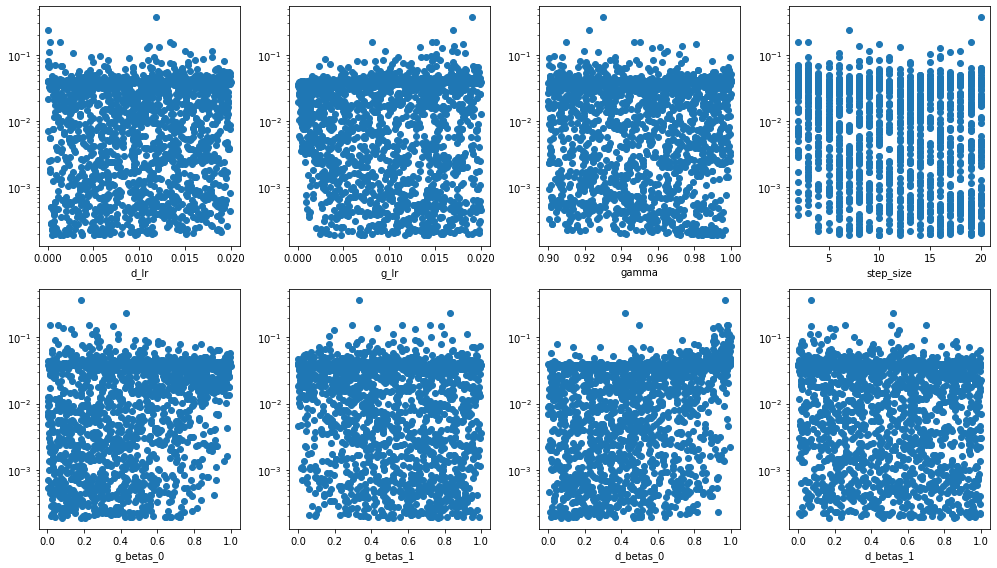

In [16]:
plot_bivariate(burv_results)

# 11. EINS

In [11]:
# Read in the EINS results
eins_results = pd.read_csv("fasrc_results/ray_tune_eins_adam.csv", usecols=np.arange(1,22))
eins_results = get_expanded_df(eins_results, optim="adam")
eins_results.loc[eins_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
618,1.100361,2021-11-14_18-24-20,holy7c24203.rc.fas.harvard.edu,0,0.019622672851965728,0.013313248158843939,0.98867697134600918,"[0.66287756, 0.78830006]","[0.51277031, 0.09922194]",12,40,50,4,2
576,1.182924,2021-11-14_18-22-10,holy7c24203.rc.fas.harvard.edu,1,0.0016626076755501336,0.018389883589516067,0.95076771759605216,"[0.36577465, 0.44827737]","[0.27069082, 0.98781809]",14,50,50,4,5
10,1.099743,2021-11-14_17-55-15,holy7c24203.rc.fas.harvard.edu,2,0.0049323404452599256,0.01741841048035311,0.98239325067626304,"[0.48322472, 0.81221597]","[0.61294938, 0.36372793]",19,40,50,3,5
71,1.121538,2021-11-14_17-56-17,holy7c24203.rc.fas.harvard.edu,3,0.014747434998428817,0.016341959189231651,0.99130678856012755,"[0.13979895, 0.69997109]","[0.04317054, 0.52559446]",13,20,40,4,3
329,1.106852,2021-11-14_18-09-42,holy7c24203.rc.fas.harvard.edu,4,0.016195778125634986,0.017800718668664093,0.96188480981460556,"[0.41008381, 0.76790429]","[0.12217758, 0.19519037]",15,50,50,2,4
569,1.182666,2021-11-14_18-22-14,holy7c24203.rc.fas.harvard.edu,5,0.00056204249102786215,0.017352886803024443,0.9823329920486642,"[0.05519296, 0.32670851]","[0.65131133, 0.99250127]",15,20,50,2,4
946,0.963145,2021-11-14_18-43-03,holy7c24203.rc.fas.harvard.edu,6,0.01193061114021309,0.014757737962090883,0.94812914657589875,"[0.82571262, 0.12144184]","[0.75612857, 0.6972567]",4,50,30,2,4
873,1.148749,2021-11-14_18-38-50,holy7c24203.rc.fas.harvard.edu,7,0.0077419893348008809,0.019308815080151479,0.93977897168300562,"[0.23745964, 0.43346432]","[0.88629235, 0.67871114]",15,30,50,4,5
1407,1.204535,2021-11-14_19-08-35,holy7c24203.rc.fas.harvard.edu,8,0.0096369612606720528,0.012478080003067743,0.98858128637553178,"[0.84637047, 0.92947719]","[0.03402152, 0.30600671]",11,40,20,5,3
278,1.049749,2021-11-14_18-07-27,holy7c24203.rc.fas.harvard.edu,9,0.016959498741291348,0.018307061720271973,0.98197446187984827,"[0.13806139, 0.22043134]","[0.01561498, 0.38155649]",16,40,50,4,3


# 12. HEA

In [13]:
# Read in the HEA results
hea_results = pd.read_csv("fasrc_results/ray_tune_hea_adam.csv", usecols=np.arange(1,22))
hea_results = get_expanded_df(hea_results, optim="adam")
hea_results.loc[hea_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1772,1.182369e-09,2021-11-15_16-31-11,holy7c24203.rc.fas.harvard.edu,0,0.016818687195466909,0.019200507698070912,0.93776156313612791,"[0.38808966, 0.88311579]","[0.39247804, 0.80629506]",13,20,30,2,2
1823,2.153391e-09,2021-11-15_16-33-12,holy7c24203.rc.fas.harvard.edu,1,0.010022938704308929,0.0075909402892882696,0.97595509472670938,"[0.38507265, 0.66592619]","[0.50096283, 0.00676169]",5,30,50,4,3
1018,7.136220e-10,2021-11-15_16-21-04,holy7c24203.rc.fas.harvard.edu,2,0.0059949237737269212,0.0091285149424974576,0.92911300383460427,"[0.05834404, 0.18113021]","[0.43724255, 0.69589482]",18,50,50,3,4
149,1.066434e-09,2021-11-15_16-06-51,holy7c24203.rc.fas.harvard.edu,3,0.002497558597753424,0.012980040198643425,0.92340604861464626,"[0.39556119, 0.8307752]","[0.88406968, 0.84766962]",18,20,30,5,4
655,1.152584e-09,2021-11-15_16-14-14,holy7c24203.rc.fas.harvard.edu,4,0.0012245791754285772,0.018357755789163242,0.94588935609793012,"[0.56166167, 0.68105714]","[0.8974246, 0.70114744]",9,30,50,3,2
181,3.174361e-10,2021-11-15_16-07-18,holy7c24203.rc.fas.harvard.edu,5,0.00195769840854613,0.010861668337087982,0.95003910549481241,"[0.2306765, 0.65763986]","[0.12032453, 0.25102168]",10,30,40,2,4
462,3.587127e-10,2021-11-15_16-12-15,holy7c24203.rc.fas.harvard.edu,6,0.0035862235397147563,0.018151170406050264,0.9370156458083776,"[0.31513985, 0.29894257]","[0.34206228, 0.85235759]",17,30,40,2,3
789,1.689041e-09,2021-11-15_16-17-30,holy7c24203.rc.fas.harvard.edu,7,0.016571161170983957,0.014091218993764034,0.9188625067266939,"[0.16355336, 0.39800136]","[0.62051388, 0.2966492]",18,40,50,2,5
237,7.336395e-10,2021-11-15_16-08-52,holy7c24203.rc.fas.harvard.edu,8,0.00060098298012296837,0.01264753519670604,0.95710768263522372,"[0.63085335, 0.81289284]","[0.56437422, 0.22023844]",12,30,40,2,4
559,5.483735e-10,2021-11-15_16-13-35,holy7c24203.rc.fas.harvard.edu,9,0.0021266943857337741,0.018961461880126342,0.97490912911733374,"[0.31348707, 0.3466119]","[0.75397888, 0.79914066]",7,40,30,4,3


# 13. ACA

In [4]:
# Read in the ACA results
aca_results = pd.read_csv("fasrc_results/ray_tune_aca_adam.csv", usecols=np.arange(1,22))
aca_results = get_expanded_df(aca_results, optim="adam")
aca_results.loc[aca_results.groupby("seed")["mean_squared_error"].idxmin()]

,mean_squared_error,date,hostname,seed,d_lr,g_lr,gamma,g_betas,d_betas,step_size,d_n_hidden_units,g_n_hidden_units,d_n_hidden_layers,g_n_hidden_layers
1029,0.204041,2021-12-06_04-18-02,holy7c24101.rc.fas.harvard.edu,0,0.0074291690929626022,0.011294843119916369,0.93761859252600266,"[0.63045621, 0.63722217]","[0.14549028, 0.28716243]",20,50,40,4,3
34,0.145365,2021-12-05_23-08-16,holy7c24101.rc.fas.harvard.edu,1,0.015747791818339549,0.010344428086311119,0.98643679101682169,"[0.39560684, 0.33626706]","[0.12936505, 0.25863143]",8,20,50,2,3
465,0.174472,2021-12-06_01-16-39,holy7c24101.rc.fas.harvard.edu,2,0.0031177973998204713,0.0063764927064860113,0.99125596721561671,"[0.23796747, 0.23514021]","[0.87640672, 0.89291233]",9,20,30,3,2
1068,0.192020,2021-12-06_04-25-48,holy7c24101.rc.fas.harvard.edu,3,0.013389941960608493,0.0081749201662284065,0.99820383235148469,"[0.61802396, 0.93851731]","[0.70754338, 0.97448414]",19,50,20,4,3
1097,0.135086,2021-12-06_04-29-10,holy7c24101.rc.fas.harvard.edu,4,0.00093618095162488891,0.0014148811247197426,0.99956297859137611,"[0.65372654, 0.55785936]","[0.68166835, 0.54224536]",20,50,30,3,3
460,0.167851,2021-12-06_01-00-37,holy7c24101.rc.fas.harvard.edu,5,0.019794166270141814,0.012214573590497779,0.91717579653625836,"[0.03947762, 0.84341384]","[0.45223709, 0.85382234]",13,20,40,2,2
1074,0.171176,2021-12-06_04-19-30,holy7c24101.rc.fas.harvard.edu,6,0.0017272055761283185,0.011804575336223777,0.99660111883821023,"[0.61842224, 0.74617732]","[0.52029576, 0.69373606]",20,30,20,5,3
435,0.148413,2021-12-06_01-33-17,holy7c24101.rc.fas.harvard.edu,7,0.00094032420535063459,0.006410162181172855,0.99249693920407711,"[0.68284747, 0.63978818]","[0.10444668, 0.00483392]",7,30,50,4,5
491,0.179412,2021-12-06_01-22-09,holy7c24101.rc.fas.harvard.edu,8,0.015077383538812378,0.014492873497015394,0.97626010523966056,"[0.78598618, 0.67226095]","[0.22098849, 0.74166132]",19,50,30,3,2
1184,0.198556,2021-12-06_04-51-51,holy7c24101.rc.fas.harvard.edu,9,0.01972011420445495,0.0099654296043896872,0.96034134782378144,"[0.06217278, 0.28319416]","[0.47754744, 0.09452914]",12,30,50,5,5


# All experiments

In [43]:
def plot_experiments(df_list, names):
    fig, ax = plt.subplots(figsize=(10, 8))
    for df, name in zip(df_list, names):
        df_subset = df.sort_values("mean_squared_error")[:150]
        x_vals = [float(x_i) for x_i in df_subset["d_lr"]]
        y_vals = [float(y_i) for y_i in df_subset["g_lr"]]
        ax.scatter(x_vals, y_vals, label=name, s=500, alpha=0.25)
    ax.set_xlabel("d_lr")
    ax.set_ylabel("g_lr")
    ax.legend()
    plt.show()

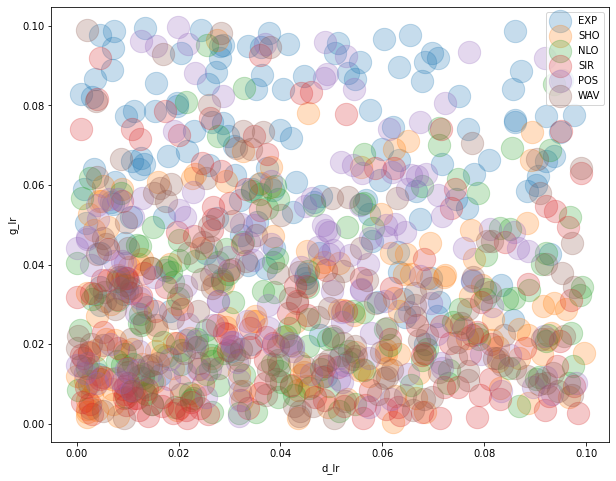

In [48]:
df_list = [exp_results, sho_results, nlo_results, sir_results, pos_results, wav_results]
names = ["EXP", "SHO", "NLO", "SIR", "POS", "WAV"]

plot_experiments(df_list, names)

In [ ]:
# ask Marios and Agusto about their non-linear equations
# check out AsyncHyperBandScheduler to maybe speed up tuning
# Burgers equations
# more applied equations: https://arxiv.org/pdf/2006.14372.pdf (curriculum learning example)
# modified gravity equations (coupled non-linear)